In order to simplify the controller for the bonus, we used simiplified the dynamics. This controller has inputs as torques on the 3 body axes and an overall thrust vector. This makes it easier to control the drone, but encompasses the same dynamics, slightly rewritten. 

Launch from ground and ascend vertically until 1m
above ground. Move in a straight line 1m above ground at an average
speed of 1m/s for 5m, stop (hover), yaw 90 deg to the left, move in another
straight line for 5m, stop (hover), land vertically with a speed of no more
than 1cm/s.

In [1]:
import sympy as sym
import numpy as np
from scipy import linalg
sym.init_printing()

In [2]:
grav = 9.81 # The acceleration due to gravity in m/s^2

Ixx = 0.0023  # The moment of inertia of the quadrotor in 
Iyy = 0.0023  # The mass of the quadrotor in kg
Izz = 0.00466 # The mass of the quadrotor in kg
l = 0.127       # The distance from the quadrotor frame to the mocap markers in meters
C_l = 0.86        # The lift coefficient
mass = 0.86      # The mass of the quad (kg)

In [3]:
# Define position
px_inW, py_inW, pz_inW = sym.symbols('p_x, p_y, p_z')
p_inW = sym.Matrix([[px_inW],
                    [py_inW],
                    [pz_inW]])

# Define velocity
vx_inB, vy_inB, vz_inB = sym.symbols('v_x, v_y, v_z')
v_inB = sym.Matrix([[vx_inB],
                    [vy_inB],
                    [vz_inB]])

# Define roll (phi), pitch (theta), and yaw (psi) angles
phi, theta, psi = sym.symbols('phi, theta, psi')

# Define angular velocities
wx_inB, wy_inB, wz_inB = sym.symbols('omega_x, omega_y, omega_z')
w_inB = sym.Matrix([[wx_inB],
                    [wy_inB],
                    [wz_inB]])

# Define roll, pitch, and yaw rotation matrices that describe the bus's orientation in the 
# world frame
Rx = sym.Matrix([[1,            0,             0],
                 [0, sym.cos(phi), -sym.sin(phi)],
                 [0, sym.sin(phi),  sym.cos(phi)]])
Ry = sym.Matrix([[ sym.cos(theta), 0, sym.sin(theta)],
                 [              0, 1,              0],
                 [-sym.sin(theta), 0, sym.cos(theta)]])
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0],
                 [sym.sin(psi),  sym.cos(psi), 0],
                 [           0,             0, 1]])
R_ofB_inW = Rz @ Ry @ Rx
R_ofW_inB = R_ofB_inW.T

# Define inputs
taux_inB, tauy_inB, tauz_inB, fz_inB = sym.symbols('tau_x, tau_y, tau_z, f_z')

# Get the net torque vector
tau_inB = sym.Matrix([[taux_inB],
                      [tauy_inB],
                      [tauz_inB]])
tau_inB = sym.simplify(tau_inB)

# Get the gravity force and convert to body coordiantes
grav_inW = sym.Matrix([[0.],
                       [0.],
                       [-mass * grav]])
grav_inB = R_ofW_inB @ grav_inW

# Get the net force vector
f_inB = grav_inB + sym.Matrix([[0.],
                               [0.],
                               [fz_inB]])
f_inB = sym.simplify(f_inB)

# Assemble the moment of inertia matrix
I_inB = sym.Matrix([[Ixx, 0.,  0.],
                    [0.,  Iyy, 0.],
                    [0.,  0.,  Izz]])

v_inW = R_ofB_inW @ v_inB
xyz_dot = sym.simplify(v_inW)
sym.N(xyz_dot,3)

v_inB_dot = (1 / mass) * (f_inB - w_inB.cross(mass * v_inB))
v_inB_dot = sym.simplify(v_inB_dot)
sym.N(v_inB_dot,3)

# Define the transformation that takes roll, pitch, and yaw rates to body-fixed angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.Matrix.hstack(ex, Rx.T@ey, (Ry@Rx).T@ez)

# Invert the transformation to get a matrix that takes body-fixed angular rates to 
# roll, pitch, and yaw rates
M_inv = sym.simplify(M.inv())

# Convert the body-fixed angular rates to roll, pitch, and yaw rates
rpy_dot = sym.simplify(M_inv@w_inB)
sym.N(rpy_dot,3)

# Apply Euler's equation to get the time derivative of the angular velocities of the
# quadrotor in the quadrotor frame
w_inB_dot = I_inB.inv() @ (tau_inB - w_inB.cross(I_inB@w_inB))
w_inB_dot = sym.simplify(w_inB_dot)
sym.N(w_inB_dot, 3)

f = sym.Matrix.vstack(xyz_dot,
                      v_inB_dot,
                      rpy_dot,
                      w_inB_dot)

In [4]:
# Finding the equilbrium points
px, py, pz, vx, vy, vz, wx, wy, wz = px_inW, py_inW, pz_inW, vx_inB, vy_inB, vz_inB, wx_inB, wy_inB, wz_inB # easier to understand
taux, tauy, tauz, fz = taux_inB, tauy_inB, tauz_inB, fz_inB
pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze = 0,0,0,0,0,0,0,0,0,0,0,0
tauxe, tauye, tauze, fze = 0,0,0,9.81*mass
f_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), f)
# When the values are plugged into the dynamics, we get a zero vector, which means it's at equilbrium
f_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)

array([[0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [1.24344979e-14],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00]])

In [5]:


# Finding the coefficient matrices
# The A matrix represents the coefficient matrix of the dynamics, so we must take the Jacobian of the drone dynamics (f) with respect to the states
A_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), f.jacobian([px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz]))
A = A_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)
sym.Matrix(A)


⎡0  0  0  1.0   0    0     0     0    0   0    0    0 ⎤
⎢                                                     ⎥
⎢0  0  0   0   1.0   0     0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0   1.0    0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0    9.81  0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0   -9.81   0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0    0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0  1.0   0    0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0   1.0   0 ⎥
⎢                                                     ⎥
⎢0  0  0   0    0    0     0     0    0   0    0   1.0⎥
⎢                                               

In [6]:


# The B matrix represents the coefficient matrix of the control inputs, so we must take the Jacobian of the drone dynamics (f) with respect to 
# the controller inputs
B_ = sym.lambdify((px, py, pz, vx, vy, vz, phi, theta, psi, wx, wy, wz, taux, tauy, tauz, fz), f.jacobian([taux, tauy, tauz, fz]))
B = B_(pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze, tauxe, tauye, tauze, fze)
sym.Matrix(B)

⎡       0                 0                 0                 0        ⎤
⎢                                                                      ⎥
⎢       0                 0                 0                 0        ⎥
⎢                                                                      ⎥
⎢       0                 0                 0                 0        ⎥
⎢                                                                      ⎥
⎢       0                 0                 0                 0        ⎥
⎢                                                                      ⎥
⎢       0                 0                 0                 0        ⎥
⎢                                                                      ⎥
⎢       0                 0                 0          1.16279069767442⎥
⎢                                                                      ⎥
⎢       0                 0                 0                 0        ⎥
⎢                                                  

In [7]:
def lqr(A, B, Q, R):
    P = linalg.solve_continuous_are(A, B, Q, R)
    K = linalg.inv(R) @ B.T @ P
    return K, P

# uses Bryson's Rule
# Qc= np.diag([1/10**2, 1/10**2, 1/10**2, 1/10**2, 1/10**2, 1/10**2, 1/10**2, 1/10**2, 1/10**2, 1/40**2, 1/40**2, 1/40**2])

Qc= np.diag([1/50**2, 1/50**2, 1/10**2, 1/100**2, 1/100**2, 1/100**2, 1/50**2, 1/100**2, 1/100**2, 1/40**2, 1/40**2, 1/40**2])
Rc = np.diag([1/0.3**2, 1/0.3**2, 1/0.3**2, 1/15**2])

K, P = lqr(A, B, Qc, Rc)
K = np.array(K)
             

In [12]:
m_e = np.array([pxe, pye, pze, vxe, vye, vze, phie, thetae, psie, wxe, wye, wze])
n_e = np.array([0, 0, 0, 9.81*mass])

xhat = np.zeros(12,)
n = np.zeros(4,)
stage = 0
count = 0

phat_history = np.array([xhat[:3]])
ang_history = np.array([xhat[6:9]])

dt = 0.01
for i in range(2500):
        if stage == 0:
            pdes = np.array([0, 0, 1])
            if xhat[2] > 1:
                stage = 1
                print("Stage 0:", i * dt)
        elif stage == 1:
            pdes = np.array([1, 0, 1])
            if xhat[0] > 1:
                stage = 2
                print("Stage 1:", i * dt)
        elif stage == 2:
            pdes = np.array([1, 0, 1])
            count += 1
            if count > 50:
                stage = 3
                count = 0
                print("Stage 2:", i * dt)
        elif stage == 3:
            xdes = np.array([1, 0, 1, 0, 0, 0, 0, 0, np.pi/2, 0, 0, 0])
            if xhat[8] < np.pi/2:
                stage = 4
                print("Stage 3:", i * dt)
        elif stage == 4:
            # move in another straight line
            pdes = np.array([1, 5, 1])
            if xhat[1] > 5:
                stage = 5
                print("Stage 4:", i * dt)
        elif stage == 5:
            # hover
            pdes = np.array([1, 5, 1])
            count += 1
            if count > 50:
                stage = 6
                count = 0
                print("Stage 5:", i * dt)
        elif stage == 6:
            # land down
            pdes = np.array([1, 5, 0])
            if xhat[2] < 0:
                stage = 7
                print("Stage 6:", i * dt)
        else:
            if xhat[2] < 0:
                print("Simulation Done")
                break
            pdes = np.array([1, 1, 0])
            

        #Calculate x desired
        x_des = np.block([pdes, np.zeros(9)])

        #Find inputs using tracking and linear feedback
        u = -K@(xhat - x_des)
        inputs = u + n_e

        xhat += dt * (A@xhat + B@u)

        phat_history = np.block([[phat_history], [xhat[:3]]])
        ang_history = np.block([[ang_history], [xhat[6:9]]])


Stage 0: 2.52
Stage 1: 5.09
Stage 2: 5.6000000000000005
Stage 3: 5.61
Stage 4: 8.21
Stage 5: 8.72
Stage 6: 11.25
Simulation Done


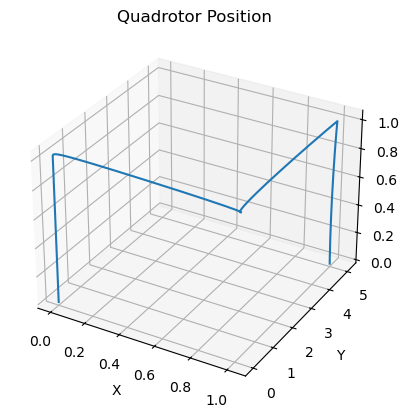

In [13]:
# Plot the results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(phat_history[:,0], phat_history[:,1], phat_history[:,2])
ax.set_title('Quadrotor Position')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

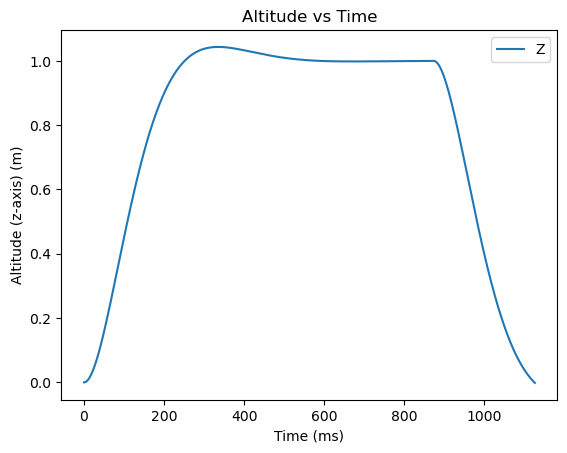

In [14]:
# Plot the positions with respect to time
plt.plot(phat_history[:,2], label='Z')
plt.title('Altitude vs Time')
plt.xlabel('Time (ms)')
plt.ylabel('Altitude (z-axis) (m)')
plt.legend()    
plt.show()


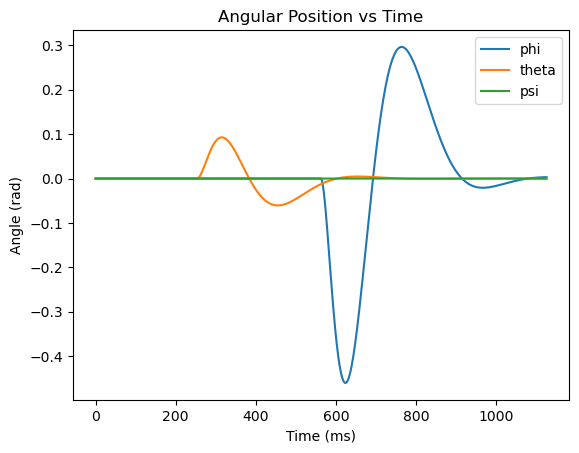

In [15]:
# Plot angular positions with respect to time
plt.plot(ang_history[:,0], label='phi')
plt.plot(ang_history[:,1], label='theta')
plt.plot(ang_history[:,2], label='psi')
plt.title('Angular Position vs Time')
plt.xlabel('Time (ms)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.show()
